In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
from itertools import combinations

IMG_PATH = "_img"
CACHE_PATH = "../fitting/_cache"
if not os.path.isdir(IMG_PATH): os.mkdir(IMG_PATH)
if not os.path.isdir(CACHE_PATH): os.mkdir(CACHE_PATH)

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
import joblib

from astroML.utils.decorators import pickle_results

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as  mpatches
import seaborn as sns

sns.set(context="talk", style="ticks", palette="colorblind", color_codes=True)

from MaStarChecks.io import load_libraries
from MaStarChecks.preprocessing import build_train_test
from MaStarChecks.plotting.analysis import build_comparison_table
from MaStarChecks.plotting.styles import *

PROCESSED_PATH = os.path.join("../fitting/_data", "processed-libraries-v3.1.1")
CLASSIFIED_PATH = "../fitting/_data/classified-mastar-v3.1.1-cleaned-v2-gsl"

LABELS = ("GSL", "MaStar",)
Y_COLUMNS = ["TEFF", "LOGG", "MET", "ALPHAM"]

def get_range(x, data=None, n=2):
    if data is None:
        xmin, xmax = x.min(), x.max()
    else:
        xmin, xmax = data[x].min(), data[x].max()
    return np.linspace(xmin, xmax, n)

units = dict(zip(Y_COLUMNS, [r"K", r"", r"", r""]))
cols = {label:f"{column}~({unit})" if unit else column for label, column, unit in zip(Y_COLUMNS, [r"$T_\mathrm{eff}$", r"$\log{g}$", r"$[\mathrm{Fe}/\mathrm{H}]$", r"$[\alpha/\mathrm{Fe}]$"], units.values())}

In [2]:
# TODO: use the spectral energy distributions in physical units to improve the logg estimation

spectra, catalogues = load_libraries(labels=LABELS, libraries_path=PROCESSED_PATH, use_cache=True, cache_path=CACHE_PATH)

catalogue = pd.DataFrame()
for label, c in catalogues.items():
    c["LIBRARY"] = label
    catalogue = catalogue.append(c, ignore_index=True)

catalogue.rename(columns=cols, inplace=True)
spectra = pd.concat([s["FLUX"] for label, s in spectra.items()], axis="index", ignore_index=True)

# spectra.loc[catalogue.LIBRARY=="MaStar"].sample(n=10, random_state=123).T.plot(lw=1)

catalogue[cols.get("TEFF")] = np.log10(catalogue[cols.get("TEFF")])

y = catalogue.filter(items=list(cols.values()))
# masking stars with weird alpha abundances
y = y.mask((catalogue.LIBRARY=="MaStar")&(y[cols.get("ALPHAM")]<=-0.1))

training_set, testing_set, labelled_set = build_train_test(labels=y, test_ratio=0.10, random_state=123, verbose=True)

X_train = spectra.loc[training_set]
y_train = y.loc[training_set]

X_test = spectra.loc[testing_set]
y_test = y.loc[testing_set]

X_labelled = spectra.loc[labelled_set]
y_labelled = y.loc[labelled_set]

training_set_gsl = training_set[catalogue.loc[training_set].LIBRARY=="GSL"]
training_set_y19 = training_set[catalogue.loc[training_set].LIBRARY=="MaStar"]
testing_set_gsl = testing_set[catalogue.loc[testing_set].LIBRARY=="GSL"]
testing_set_y19 = testing_set[catalogue.loc[testing_set].LIBRARY=="MaStar"]

y_test[cols.get("TEFF")] = 10**y_test[cols.get("TEFF")]

labelled set : 30430
training set : 27387
testing set  : 3043


In [3]:
catalogue.loc[labelled_set].loc[catalogue.loc[labelled_set].LIBRARY=="MaStar"].ID.tolist()

['27-479',
 '3-10042073',
 '3-10044956',
 '3-10057783',
 '3-10304716',
 '3-103225210',
 '3-103285545',
 '3-103344770',
 '3-103344772',
 '3-103515566',
 '3-103517906',
 '3-103625601',
 '3-103681208',
 '3-103681233',
 '3-103681350',
 '3-103734428',
 '3-103734474',
 '3-103786965',
 '3-103886218',
 '3-103935987',
 '3-104033750',
 '3-104175208',
 '3-104266063',
 '3-104554432',
 '3-104594213',
 '3-104594947',
 '3-104619290',
 '3-104670580',
 '3-104707693',
 '3-104731024',
 '3-104765602',
 '3-10503039',
 '3-10506842',
 '3-105072035',
 '3-105265171',
 '3-105623854',
 '3-105812035',
 '3-105895567',
 '3-105895582',
 '3-105915183',
 '3-105948300',
 '3-1064802',
 '3-10769895',
 '3-108151077',
 '3-108181176',
 '3-108240100',
 '3-108269860',
 '3-108270014',
 '3-108270118',
 '3-108270477',
 '3-10834340',
 '3-108585754',
 '3-108585851',
 '3-108585878',
 '3-108655582',
 '3-108726951',
 '3-108799723',
 '3-10882374',
 '3-108873273',
 '3-109069581',
 '3-109142765',
 '3-109151426',
 '3-109190081',
 '3-1091

In [4]:
pickle_filename = "../busy-week/_cache/estimator-mor-v3.1.1-cleaned-v2-gsl.pk"

mor = joblib.load(pickle_filename)

In [5]:
from MaStarChecks.constants import WAVELENGTH_NORM
from copy import deepcopy as copy


# resample GSL to match in size MaStar DR1
X_noisy = copy(X_test)
X_diff = X_noisy.loc[testing_set_gsl].sample(n=testing_set_gsl.size-testing_set_y19.size, random_state=123)
X_noisy = X_noisy.drop(index=X_diff.index)
testing_set_gsl = testing_set_gsl.difference(X_diff.index)

# perturbate GSL with a set SNR
SNR = np.inf
norm_wl = (WAVELENGTH_NORM[0]<=X_test.columns)&(X_test.columns<=WAVELENGTH_NORM[1])
norm_fl = X_test.loc[testing_set_gsl, norm_wl].agg(np.median, axis="columns")
X_noisy.loc[testing_set_gsl] = X_test.loc[testing_set_gsl] + np.random.randn(*X_test.loc[testing_set_gsl].shape) * norm_fl.values[:,None]/SNR

y_model = pd.DataFrame(index=X_noisy.index, columns=y_test.columns, data=mor["mode"].predict(X_noisy))
y_model[cols.get("TEFF")] = 10**y_model[cols.get("TEFF")]

model_eval = pd.merge(y_model.add_suffix(" model"), y_test.add_suffix(" true"), left_index=True, right_index=True, how="inner")
# model_eval = model_eval.loc[y_test[cols.get("LOGG")]<=3.5]
residuals = model_eval.filter(like="model").rename(columns=lambda s: s.replace(" model",""))-model_eval.filter(like="true").rename(columns=lambda s: s.replace(" true",""))
residuals = residuals.add_prefix("$\Delta$")
model_eval = pd.concat((model_eval,residuals), axis="columns")
model_eval["library"] = catalogue.loc[X_noisy.index].LIBRARY.replace({"MaStar":"MaStarDR1"})

$\Delta$$T_\mathrm{eff}$~(K)
GSL (S/N=inf) -1.99 43.26
MaStarDR1 2.93 239.65
$\Delta$$\log{g}$
GSL (S/N=inf) -0.0 0.21
MaStarDR1 0.02 0.38
$\Delta$$[\mathrm{Fe}/\mathrm{H}]$
GSL (S/N=inf) -0.01 0.16
MaStarDR1 -0.02 0.24
$\Delta$$[\alpha/\mathrm{Fe}]$
GSL (S/N=inf) 0.01 0.09
MaStarDR1 -0.01 0.08


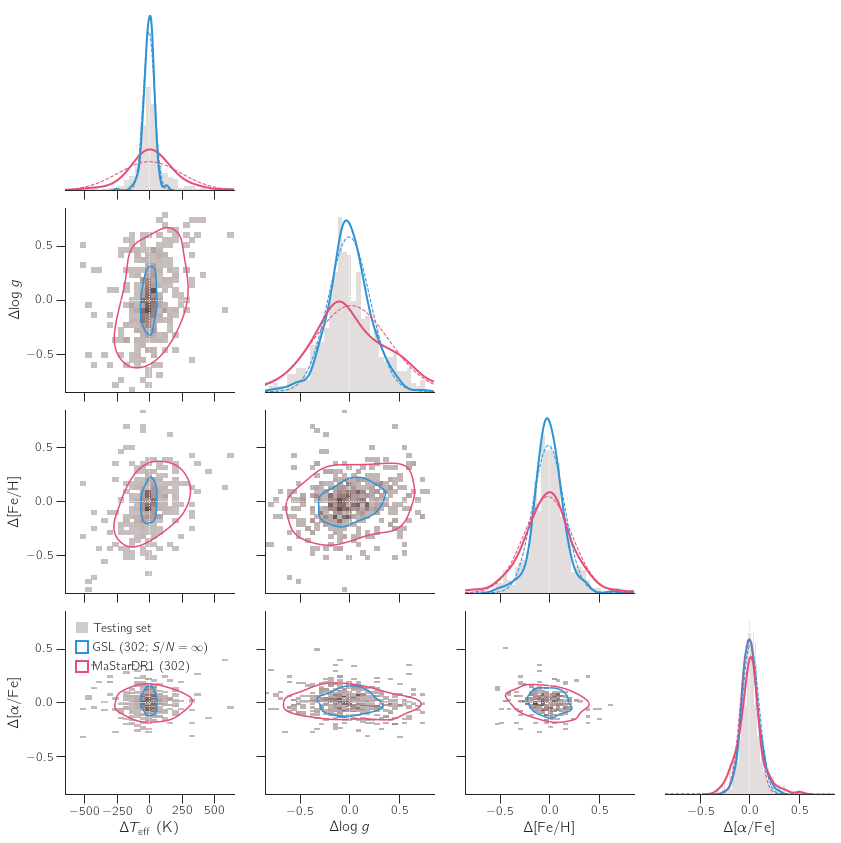

In [6]:
def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*(x - mu)**2/sigma**2)

limits = dict(zip(residuals.columns, [(-650,650)] + 3*[(-0.85,+0.85)]))
ticks = dict(zip(residuals.columns, [250] + 3*[0.5]))

g = sns.pairplot(residuals, kind="hist", corner=True, height=3,
                 plot_kws={"color":LIGHT_COLOR, "bins":70, "stat":"density", "pthresh":0.0},
                 diag_kws={"lw":0, "fc":LIGHT_COLOR, "bins":70, "stat":"density", "pthresh":0.0},
                 grid_kws={"diag_sharey":False}
)
g.map_diag(lambda x, color, label: plt.axvline(ls=":", lw=1, color="w"))
g.map_lower(lambda x, y, color: plt.axvline(ls=":", lw=1, color="w"))
g.map_lower(lambda x, y, color: plt.axhline(ls=":", lw=1, color="w"))

for (i, column), ax in zip(enumerate(residuals.columns), g.diag_axes):
    mu_m20 = np.mean(residuals.loc[model_eval.library=="GSL",column])
    mu_y19 = np.mean(residuals.loc[model_eval.library=="MaStarDR1",column])
    mu_y19_test = mu_y19 - mu_m20
    
    sigma_m20 = np.std(residuals.loc[model_eval.library=="GSL",column])
    sigma_y19 = np.std(residuals.loc[model_eval.library=="MaStarDR1",column])
    sigma_y19_test = np.sqrt(np.abs(sigma_y19**2 - sigma_m20**2))
    
    print(column)
    # print(np.mean(residuals[column]).round(2), np.std(residuals[column]).round(2))
    print(f"GSL (S/N={SNR})", mu_m20.round(2), sigma_m20.round(2))
    print("MaStarDR1", mu_y19_test.round(2), sigma_y19_test.round(2))
    
    sns.kdeplot(x=residuals.loc[model_eval.library=="GSL",column], color=GSL_COLOR, lw=2, ax=ax, clip=limits[column])
    sns.kdeplot(x=residuals.loc[model_eval.library=="MaStarDR1",column], color=Y19_COLOR, lw=2, ax=ax, clip=limits[column])
    
    support = np.linspace(*limits[column], 1000)
    ax.plot(support, gaussian(support, mu=mu_m20, sigma=sigma_m20), "--", color=GSL_COLOR, lw=1)
#     ax.plot(support, gaussian(support, mu=mu_y19, sigma=sigma_y19), ":", color=Y19_COLOR, lw=1)
    ax.plot(support, gaussian(support, mu=mu_y19_test, sigma=sigma_y19_test), "--", color=Y19_COLOR, lw=1)
    
    g.diag_axes[i].set_xlim(*limits[column])
    g.diag_axes[i].xaxis.set_major_locator(ticker.MultipleLocator(ticks[column]))
for (column_x,column_y), (j,i) in zip(combinations(residuals.columns, 2), (combinations([0,1,2,3], 2))):
    sns.kdeplot(x=residuals.loc[model_eval.library=="GSL",column_x], y=residuals.loc[model_eval.library=="GSL",column_y], levels=(0.32,), color=GSL_COLOR,
                linewidths=1.5, ax=g.axes[i,j])
    sns.kdeplot(x=residuals.loc[model_eval.library=="MaStarDR1",column_x], y=residuals.loc[model_eval.library=="MaStarDR1",column_y], levels=(0.32,), color=Y19_COLOR,
                linewidths=1.5, ax=g.axes[i,j])
    
    g.axes[i,j].set_xlim(*limits[column_x])
    g.axes[i,j].set_ylim(*limits[column_y])
    g.axes[i,j].xaxis.set_major_locator(ticker.MultipleLocator(ticks[column_x]))
    g.axes[i,j].yaxis.set_major_locator(ticker.MultipleLocator(ticks[column_y]))

handles = [mpatches.Patch(facecolor="0.8", label="Testing set"),
           mpatches.Patch(facecolor="none", edgecolor=GSL_COLOR, lw=2,
           label="GSL ({}; $S/N={}$)".format((model_eval.library=="GSL").sum(),SNR if not np.isinf(SNR) else "\infty")),
           mpatches.Patch(facecolor="none", edgecolor=Y19_COLOR, lw=2,
           label="MaStarDR1 ({})".format((model_eval.library=="MaStarDR1").sum()))]
legend = g.axes[3,0].legend(handles=handles, loc=2)
g.fig.savefig(f"_img/consistency-testing-snr_{SNR}.png", bbox_inches="tight")

In [7]:
gsl_catalogue = catalogue.loc[catalogue.LIBRARY=="GSL"]
gsl_spectra = spectra.loc[catalogue.LIBRARY=="GSL"]

y_gsl_true = gsl_catalogue.filter(items=cols.values())
y_gsl_model = pd.DataFrame(index=y_gsl_true.index, columns=cols.values(), data=mor["mode"].predict(gsl_spectra))

y_gsl_true[cols["TEFF"]] = 10**y_gsl_true[cols["TEFF"]]
y_gsl_model[cols["TEFF"]] = 10**y_gsl_model[cols["TEFF"]]

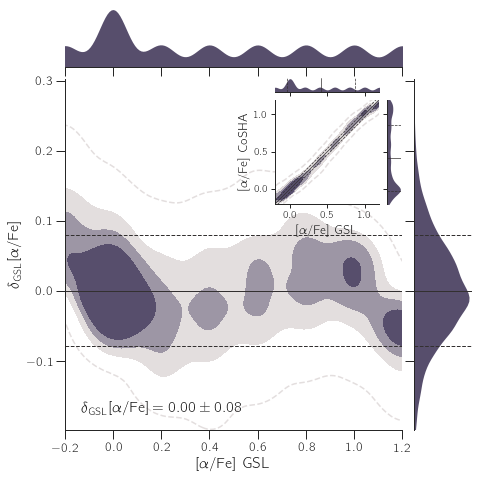

In [8]:
from MaStarChecks.plotting.analysis import delta_inset_plot


compare_with = "GSL"
comparison = build_comparison_table(y_gsl_model, y_gsl_true, labela="CoSHA", labelb=compare_with, columns=list(cols.values()), delta_prefix=r"$\delta_{\mathrm{%s}}$"%compare_with)

for label, column in cols.items():
    d = delta_inset_plot(
            comparison_table=comparison,
            column=column, unit=units.get(label,""), is_logscale=label!="TEFF",
            labelx=compare_with, labely="CoSHA", delta_prefix=r"$\delta_{\mathrm{%s}}$"%compare_with,
            guide_color="#333030"
        )
    d.fig.savefig(f"_img/{label.lower()}-residuals-inset-{compare_with.lower()}.png", bbox_inches="tight")

In [9]:
mode_predict = mor["mode"].predict(gsl_spectra)
p16_predict  = mor["P16"].predict(gsl_spectra)
p50_predict  = mor["P50"].predict(gsl_spectra)
p84_predict  = mor["P84"].predict(gsl_spectra)

mode_Teff  = mode_predict[:,0]
p16_Teff   = p16_predict[:,0]
p84_Teff   = p84_predict[:,0]
mode_G     = mode_predict[:,1]
p16_G      = p16_predict[:,1]
p84_G      = p84_predict[:,1]
mode_Fe    = mode_predict[:,2]
p16_Fe     = p16_predict[:,2]
p84_Fe     = p84_predict[:,2]
mode_alpha = mode_predict[:,3]
p16_alpha  = p16_predict[:,3]
p84_alpha  = p84_predict[:,3]

std_Teff  = np.abs(p84_Teff - p16_Teff)/2     # STD T_eff en LOG
std_G     = np.abs(p84_G - p16_G)/2 
std_Fe    = np.abs(p84_Fe - p16_Fe)/2 
std_alpha = np.abs(p84_alpha - p16_alpha)/2

# STD T_eff LINEAL
std_Teff  = std_Teff * 10**(mode_Teff) * np.log(10)      #std[:,0] = std[:,0] * 10**(mode_predict[:,0]) * np.log(10)

# Teff, primer columna [0], logG segunda columna [1]

T_eff = mode_Teff   #len = 21847
log_G = mode_G      #len = 21847

Fe    = mode_Fe     #len = 21847
alpha = mode_alpha  #len = 21847

C = std_Teff        #LINEAL

nbins = 40

units = [r"K", r"", r"", r""]
cols = [r"$T_\mathrm{eff}$", r"$\log{g}$", r"$[\mathrm{Fe}/\mathrm{H}]$", r"$[\alpha/\mathrm{Fe}]$"]

In [10]:
from MaStarChecks.plotting.analysis import density_scatter_kde, contours_from_pdf
import matplotlib

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

x = 10**T_eff
y = log_G

delta_x, delta_y = std_Teff.mean()/5, std_G.mean()/5
rangex, rangey = (min(x), max(x)), (min(y), max(y))

# COMPUTE DENSITY (PDF) FUNCTION -------------------------------------------------------

pdf_z = density_scatter_kde(x, y, bw_method=0.2)
z = pdf_z(x, y)

levels, X, Y, Z = contours_from_pdf(
    pdf_func=pdf_z,
    range_x=rangex,
    range_y=rangey,
    deltas=(delta_x,delta_y), percentiles=(25,50,75,95),
    return_grid=True
)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

fig, axs = plt.subplots(2, 2, figsize=(14,12))
axs = axs.flatten()

stds = [std_Teff, std_G, std_Fe, std_alpha]
for i, ax in enumerate(axs):
    z = stds[i]
    norm = matplotlib.colors.TwoSlopeNorm(vcenter=np.percentile(z,50), vmin=np.percentile(z,10), vmax=np.percentile(z,90))
    t = ax.hexbin(x, y, C=z, gridsize=nbins, reduce_C_function=np.median, norm=norm,
                  cmap=sns.color_palette(f"blend:{LIGHT_COLOR},{MASTAR_COLOR}", as_cmap=True), edgecolors="none")
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])
    cb = plt.colorbar(t, ax=ax, extend="both")
    cb.set_label(r'$\sigma_{%s}$'%(cols[i].strip("$")))
    contour = ax.contour(X, Y, Z, levels=levels, origin="lower", colors="w", linewidths=1.5, linestyles=["--"]+3*["-"])
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_ylim(ax.get_ylim()[::-1])
#     ax.set_fc("0.9")
fig.tight_layout()
fig.savefig("_img/logg-teff-precisions-gsl.png", bbox_inches="tight")